In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

In [2]:
from string import punctuation
stem_punc_data = pd.read_csv('./Corona_train.csv').to_numpy()
validation_data = pd.read_csv('./Corona_validation.csv').to_numpy()

In [3]:
stemmer = PorterStemmer()
stopwords_set = stopwords.words('english')

In [4]:
def stem_punc_stopwords(data):
    for i in range(len(data)):
        text = data[i][2].lower()
        words = word_tokenize(text)
        words = [word for word in words if word not in punctuation]
        changed_words = [stemmer.stem(word) for word in words if word not in stopwords_set]
        data[i][2] = ' '.join(changed_words)
    return data

In [5]:
stem_punc_data = stem_punc_stopwords(stem_punc_data)

In [6]:
def get_word_frequency(inputData):
    allWords = []
    dictWord = {}
    for data in inputData:
        text = word_tokenize(data[2])
        for word in text:
            if (word != ' ') and (word not in dictWord):
                dictWord[word] = len(allWords)
                allWords.append(word)
    return (allWords, dictWord)

In [7]:
(stem_punc_words, stem_punc_dict) = get_word_frequency(stem_punc_data)

In [8]:
pc = [0, 0, 0]
pc[0] = stem_punc_data[stem_punc_data[:, 1] == 'Positive'].shape[0] / stem_punc_data.shape[0]
pc[1] = stem_punc_data[stem_punc_data[:, 1] == 'Neutral'].shape[0] / stem_punc_data.shape[0]
pc[2] = stem_punc_data[stem_punc_data[:, 1] == 'Negative'].shape[0] / stem_punc_data.shape[0]

In [9]:
def parameters(inputData, dictWord):
    p_wc = np.zeros((3, len(dictWord)))
    for data in inputData:
        text = word_tokenize(data[2])
        for word in text:
            if word not in dictWord: continue
            if(data[1] == 'Positive'): p_wc[0][dictWord[word]] += 1
            elif(data[1] == 'Neutral'): p_wc[1][dictWord[word]] += 1
            else: p_wc[2][dictWord[word]] += 1
    total = [0, 0, 0]
    total[0] = sum(p_wc[0])
    total[1] = sum(p_wc[1])
    total[2] = sum(p_wc[2])
    for i in range(len(total)):
        for j in range(len(p_wc[i])):
            p_wc[i][j] = (p_wc[i][j] + 1) / (total[i] + len(dictWord))
    return p_wc

In [10]:
p_wc_stem_punc = parameters(stem_punc_data, stem_punc_dict)

In [11]:
def stem_punc_predict(text, dictWord, pc, p_wc):
    text = text.lower()
    text = word_tokenize(text)
    words = [word for word in text if word not in punctuation]
    p = np.zeros((3,))
    for i in range(len(p)):
        p[i] = np.log(pc[i])
        for word in words:
            if(word in stopwords_set): continue
            word = stemmer.stem(word)
            if(word in dictWord):
                p[i] += np.log(p_wc[i][dictWord[word]])
    return np.argmax(p)

In [13]:
training_data = pd.read_csv('./Corona_train.csv').to_numpy()

In [ ]:
stem_punc_train_correct = 0
stem_punc_train_incorrect = 0
for data in training_data:
    prediction = stem_punc_predict(data[2], stem_punc_dict, pc, p_wc_stem_punc)
    if(data[1] == 'Positive' and prediction == 0): stem_punc_train_correct += 1
    elif(data[1] == 'Neutral' and prediction == 1): stem_punc_train_correct += 1
    elif(data[1] == 'Negative' and prediction == 2): stem_punc_train_correct += 1
    else: stem_punc_train_incorrect += 1
stem_punc_val_correct = 0
stem_punc_val_incorrect = 0
for data in validation_data:
    prediction = stem_punc_predict(data[2], stem_punc_dict, pc, p_wc_stem_punc)
    if(data[1] == 'Positive' and prediction == 0): stem_punc_val_correct += 1
    elif(data[1] == 'Neutral' and prediction == 1): stem_punc_val_correct += 1
    elif(data[1] == 'Negative' and prediction == 2): stem_punc_val_correct += 1
    else: stem_punc_val_incorrect += 1

In [ ]:
print(f"Stemming, Training\nCorrect: {stem_punc_train_correct}\nIncorrect: {stem_punc_train_incorrect}\nAccuracy: {stem_punc_train_correct / (stem_punc_train_correct + stem_punc_train_incorrect)}")
print(f"Stemming, Validation\nCorrect: {stem_punc_val_correct}\nIncorrect: {stem_punc_val_incorrect}\nAccuracy: {stem_punc_val_correct / (stem_punc_val_correct + stem_punc_val_incorrect)}")

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ''.join(stem_punc_data[:, 2])
text_positive = ''.join(stem_punc_data[stem_punc_data[:, 1] == 'Positive'][:, 2])
text_neutral = ''.join(stem_punc_data[stem_punc_data[:, 1] == 'Neutral'][:, 2])
text_negative = ''.join(stem_punc_data[stem_punc_data[:, 1] == 'Negative'][:, 2])
word_cloud = WordCloud(width = 800, height = 500, background_color ='white', min_font_size = 10).generate(text)
word_cloud_positive = WordCloud(width = 800, height = 500, background_color ='white', min_font_size = 10).generate(text_positive)
word_cloud_neutral = WordCloud(width = 800, height = 500, background_color ='white', min_font_size = 10).generate(text_neutral)
word_cloud_negative = WordCloud(width = 800, height = 500, background_color ='white', min_font_size = 10).generate(text_negative)

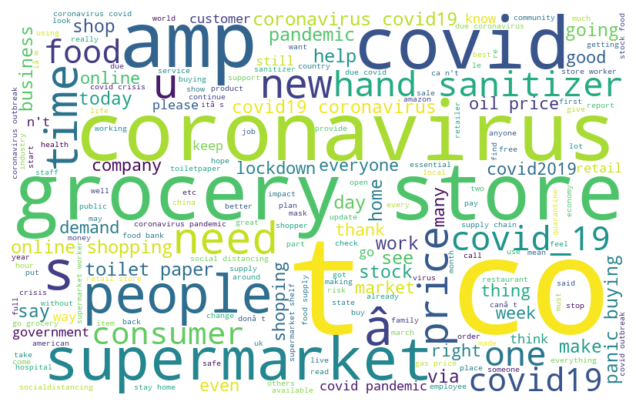

In [16]:
plt.figure(figsize=(10, 5))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()
word_cloud.to_file("wordcloud_d_all.png")
word_cloud_positive.to_file("wordcloud_d_positive.png")
word_cloud_neutral.to_file("wordcloud_d_neutral.png")
word_cloud_negative.to_file("wordcloud_d_negative.png")